
# Tech Challenge — Fase 1
**Tema:** Classificação de Doença Cardíaca (Cleveland Dataset)

> _“Se o pronto atendimento está cheio, qual paciente eu devo priorizar para avaliação cardiológica?”_  
Este notebook é a primeira versão de um **sistema de apoio à triagem**. A ideia é usar **Machine Learning** para estimar, com base em poucos dados clínicos, a probabilidade de **doença cardíaca** (0/1). Não substitui médico — apenas **ganho de velocidade** na triagem.

## Roteiro
1. Conhecer minimamente os dados;
2. Preparar as variáveis sem “vazamento” de informação;
3. Treinar / comparar modelos clássicos (LR, KNN, DT);
4. Avaliar corretamente (treino/validação/teste);
5. Interpretar decisões (coeficientes/SHAP);
6. Exportar o modelo final e comentar a API.



## 1. Preparação do ambiente

Requisitos: `pandas`, `numpy`, `scikit-learn`, visualização (`matplotlib`/`seaborn`) e **SHAP** para interpretabilidade.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score, f1_score
)

import kagglehub
np.random.seed(42)



## 2. Dados (Cleveland — Kaggle/UCI)

Usaremos o dataset público **Cleveland Heart Disease**.  
O alvo é `condition` (0 = sem doença, 1 = com doença). Para manter compatibilidade com a nossa API, focaremos em **cinco variáveis**: `thal`, `ca`, `oldpeak`, `exang`, `cp`.

Vamos carregar e dar uma olhada rápida.


In [2]:

path = kagglehub.dataset_download("cherngs/heart-disease-cleveland-uci")
csv_path = f"{path}/heart_cleveland_upload.csv"
df = pd.read_csv(csv_path)

print("Shape:", df.shape)
df.head()


Shape: (297, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0



## 3. EDA rápida (Análise Exploratória de Dados)

Vamos verificar a distribuição da variável alvo, identificar possíveis valores ausentes e observar as correlações mais relevantes. O objetivo é ter uma visão clara do conjunto de dados para guiar as próximas etapas, sem entrar em uma análise exploratória extensa.


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
count,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000,297.000000
mean,54.542088,0.676768,2.158249,131.693603,247.350168,0.144781,0.996633,149.599327,0.326599,1.055556,0.602694,0.676768,0.835017,0.461279
std,9.049736,0.468500,0.964859,17.762806,51.997583,0.352474,0.994914,22.941562,0.469761,1.166123,0.618187,0.938965,0.956690,0.499340
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,56.000000,1.000000,2.000000,130.000000,243.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,0.000000,0.000000
75%,61.000000,1.000000,3.000000,140.000000,276.000000,0.000000,2.000000,166.000000,1.000000,1.600000,1.000000,1.000000,2.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,2.000000,1.000000



Valores nulos por coluna:
age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


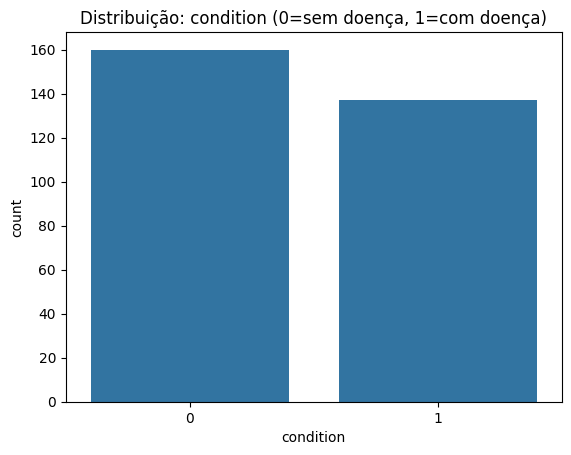

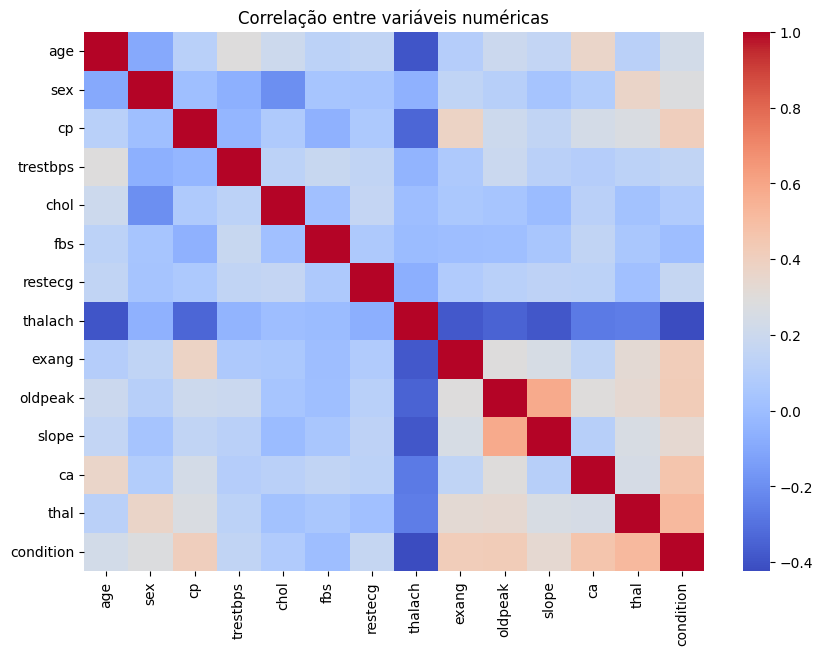

In [3]:

display(df.describe())
print("\nValores nulos por coluna:")
print(df.isnull().sum())

sns.countplot(data=df, x='condition')
plt.title('Distribuição: condition (0=sem doença, 1=com doença)')
plt.show()

plt.figure(figsize=(10,7))
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')
plt.title('Correlação entre variáveis numéricas')
plt.show()



## 4. Pré-processamento

Decisões:
- **Filtro etário 40–70**: reduz extremos que podem distorcer métricas;
- **Features**: `['thal','ca','oldpeak','exang','cp']` (compatível com a API);
- **Scaler dentro do Pipeline**: evita vazamento na validação cruzada.


In [4]:

df_filt = df[(df['age'] >= 40) & (df['age'] <= 70)].copy()

FEATURES = ['thal','ca','oldpeak','exang','cp']
TARGET = 'condition'

X = df_filt[FEATURES]
y = df_filt[TARGET]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X.shape, y.shape


((277, 5), (277,))


## 5. Modelagem

Compararemos **Regressão Logística**, **KNN (k=5)** e **Árvore de Decisão**.  
Métricas em **StratifiedKFold (k=5)**: `Accuracy`, `Recall` e `F1`.


In [5]:

models = {
    "LogisticRegression": Pipeline([("scaler", StandardScaler()),
                                    ("clf", LogisticRegression(max_iter=1000))]),
    "KNN": Pipeline([("scaler", StandardScaler()),
                     ("clf", KNeighborsClassifier(n_neighbors=5))]),
    "DecisionTree": Pipeline([("clf", DecisionTreeClassifier(random_state=42))])
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rows = []
for name, model in models.items():
    acc = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy").mean()
    rec = cross_val_score(model, X_train, y_train, cv=cv, scoring="recall").mean()
    f1s = cross_val_score(model, X_train, y_train, cv=cv, scoring="f1").mean()
    rows.append((name, acc, rec, f1s))

res_df = pd.DataFrame(rows, columns=["Modelo","Accuracy_CV","Recall_CV","F1_CV"]).sort_values("F1_CV", ascending=False)
res_df


,Modelo,Accuracy_CV,Recall_CV,F1_CV
0,LogisticRegression,0.832727,0.800000,0.817624
1,KNN,0.809899,0.742857,0.784490
2,DecisionTree,0.787374,0.752381,0.769993



## 6. Avaliação no conjunto de teste

Escolhemos o melhor pela **F1 em cross-val**, treinamos no conjunto de treino **e só então** avaliamos no teste.


Melhor modelo (CV): LogisticRegression
Accuracy: 0.7678571428571429
Recall: 0.6666666666666666
F1: 0.7346938775510204

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.79        29
           1       0.82      0.67      0.73        27

    accuracy                           0.77        56
   macro avg       0.78      0.76      0.76        56
weighted avg       0.78      0.77      0.77        56



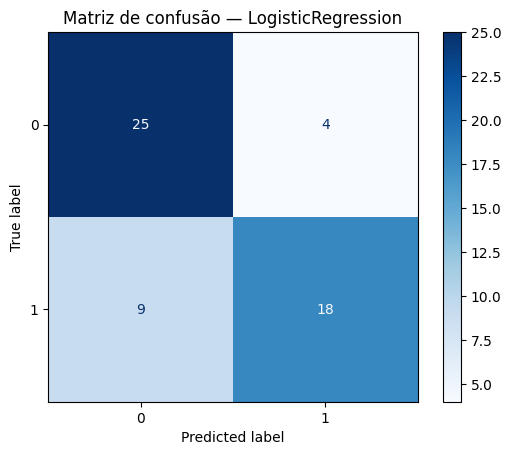

In [6]:

best_name = res_df.iloc[0]["Modelo"]
best_model = models[best_name]
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Melhor modelo (CV):", best_name)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title(f"Matriz de confusão — {best_name}")
plt.show()



## 7. Interpretação: o que o modelo está olhando?

Se o melhor for **Regressão Logística**, olhamos coeficientes (sinal/magnitude).  
Também usamos **SHAP** para uma visão global da contribuição de cada variável.


,Variável,Coeficiente
1,ca,1.191918
0,thal,0.998904
2,oldpeak,0.664747
4,cp,0.544596
3,exang,0.347787


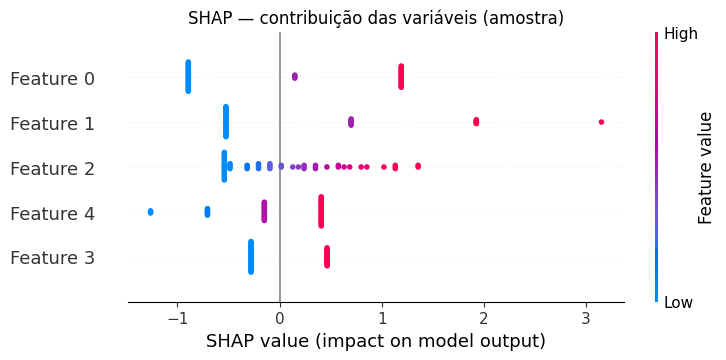

In [7]:

clf = best_model.named_steps.get("clf", best_model)

if isinstance(clf, LogisticRegression):
    coef_df = pd.DataFrame({"Variável": FEATURES, "Coeficiente": clf.coef_[0]})
    display(coef_df.sort_values("Coeficiente", key=lambda s: abs(s), ascending=False))

# SHAP (amostra para agilizar)
if "scaler" in best_model.named_steps:
    X_test_scaled = best_model.named_steps["scaler"].transform(X_test)
    explainer = shap.Explainer(clf, X_test_scaled)
    shap_values = explainer(X_test_scaled[:120])
else:
    explainer = shap.Explainer(clf, X_test)
    shap_values = explainer(X_test[:120])

shap.plots.beeswarm(shap_values, show=False)
plt.title("SHAP — contribuição das variáveis (amostra)")
plt.show()



## 8. Export do modelo (Pipeline completo)

Exportar o Pipeline completo garante que todo o fluxo de pré-processamento e predição seja executado exatamente como foi treinado. Assim, ao integrarmos o modelo na API, não precisamos nos preocupar em aplicar manualmente transformações como normalização ou codificação — tudo já está encapsulado no mesmo objeto.


In [8]:

import os
os.makedirs("app/model", exist_ok=True)
joblib.dump(best_model, "app/model/modelo_pipeline.pkl")
print("Modelo salvo em app/model/modelo_pipeline.pkl")


Modelo salvo em app/model/modelo_pipeline.pkl



## 9. Conclusão

- Entregamos um classificador funcional e interpretável, pronto para integrar à API.  
- Em contexto clinico, seria melhor priorizar **Recall** da classe 1 (evitar falsos negativos), mesmo que isso gere alguns alarmes falsos.